### EDA- Censos Argentina

In [1]:
## Imports

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from utils import read_table_into_dataframe
from utils import create_table_pdf
from utils import  dataframe_to_latex
from utils import dataframe_to_image

In [2]:
### CONNECT TO POSTGRES DATABASE
## AMBA

import psycopg2

# Establish connection parameters
dbname = 'AMBA'
user = 'postgres'
password = 'Ferm1987'
host = 'localhost'  # By default, localhost
port = '5432'  # By default, 5432

# Connect to the PostgreSQL database
try:
    conn = psycopg2.connect(
        dbname=dbname,
        user=user,
        password=password,
        host=host,
        port=port
    )

    # Create a cursor object
    cursor = conn.cursor()

    # Execute a query
    cursor.execute("SELECT version();")
    db_version = cursor.fetchone()
    print("Connected to:", db_version)

    # Commit the transaction
    conn.commit()

except psycopg2.Error as e:
    print("Error connecting to PostgreSQL:", e)

finally:
    # Close the cursor and connection
    if 'cursor' in locals() and cursor is not None:
        cursor.close()
    # if 'conn' in locals() and conn is not None:
    #     conn.close()


Connected to: ('PostgreSQL 16.1, compiled by Visual C++ build 1937, 64-bit',)


In [3]:
# Read poblacion
df = read_table_into_dataframe('public.poblacion')
if df is not None:
    print(df)

      id AñoCenso CodigoDpto            Departamento  Poblacion   Varones  \
0    206     1991       6028         Almirante Brown   450698.0  222042.0   
1    207     1991       6035              Avellaneda   344991.0  164243.0   
2    208     1991       6091             Berazategui   244929.0  120870.0   
3    209     1991       6260  Esteban Echeverría (1)   275793.0  136784.0   
4    210     1991       6270              Ezeiza (2)        NaN       NaN   
..   ...      ...        ...                     ...        ...       ...   
200  406     2022       6756              San Isidro   298777.0  139818.0   
201  407     2022       6760              San Miguel   326215.0  157244.0   
202  408     2022       6805                   Tigre   447785.0  215056.0   
203  409     2022       6840         Tres de Febrero   366377.0  173299.0   
204  410     2022       6861           Vicente López   283510.0  131723.0   

      Mujeres  VivPartTot  VivColectTot  IndMasc  Superficie  DensPob  
0  

In [4]:
# Read vCensosAmba
df = read_table_into_dataframe('public.v_censos_amba')
df=df.sort_values('nam')
if df is not None:
    print(df)
df.drop('Superficie', axis=1, inplace=True)
dataframe_to_latex(df.head(10), 'censosamba.tex')

    # Example usage:
# # Assuming 'df' is your DataFrame
# dataframe_to_image(df.head(), 'output', 'svg')  # Save as SVG image
# dataframe_to_image(df.head(), 'output', 'jpeg') # Save as JPEG image



                nam cod_depto  anio       pob       var       muj   vivpart  \
35  Almirante Brown     06028  1991  450698.0  222042.0  228656.0       NaN   
33  Almirante Brown     06028  2010  552902.0  270247.0  282655.0  156218.0   
32  Almirante Brown     06028  2022  585852.0  281842.0  301779.0  184403.0   
34  Almirante Brown     06028  2001  515556.0  252454.0  263102.0  143543.0   
94       Avellaneda     06035  2001  328980.0  155450.0  173530.0  117200.0   
..              ...       ...   ...       ...       ...       ...       ...   
75  Tres de Febrero     06840  1991  349376.0  167417.0  181959.0       NaN   
6     Vicente López     06861  2001  274082.0  127238.0  146844.0  108947.0   
4     Vicente López     06861  2022  283510.0  131723.0  149903.0  126139.0   
7     Vicente López     06861  1991  289505.0  135426.0  154079.0       NaN   
5     Vicente López     06861  2010  269420.0  125792.0  143628.0  114747.0   

    vivtotal  Superficie     sup ind_masc dens_pob 

In [5]:
df.describe()
df.shape
df.columns
df.dtypes
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 96 entries, 35 to 5
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   nam        96 non-null     object 
 1   cod_depto  96 non-null     object 
 2   anio       96 non-null     object 
 3   pob        90 non-null     float64
 4   var        90 non-null     float64
 5   muj        90 non-null     float64
 6   vivpart    72 non-null     float64
 7   vivtotal   72 non-null     float64
 8   sup        96 non-null     object 
 9   ind_masc   90 non-null     object 
 10  dens_pob   90 non-null     object 
dtypes: float64(5), object(6)
memory usage: 9.0+ KB


nam           0
cod_depto     0
anio          0
pob           6
var           6
muj           6
vivpart      24
vivtotal     24
sup           0
ind_masc      6
dens_pob      6
dtype: int64

In [6]:
numeric_features=[feature for feature in df.columns if df[feature].dtype !='O']

categorical_features=[feature for feature in df.columns if df[feature].dtype =='O']
print(f" We have {len(numeric_features)} number of numerical features ",numeric_features)
print(f" We have {len(categorical_features)} number of Categorical features ",categorical_features)

 We have 5 number of numerical features  ['pob', 'var', 'muj', 'vivpart', 'vivtotal']
 We have 6 number of Categorical features  ['nam', 'cod_depto', 'anio', 'sup', 'ind_masc', 'dens_pob']


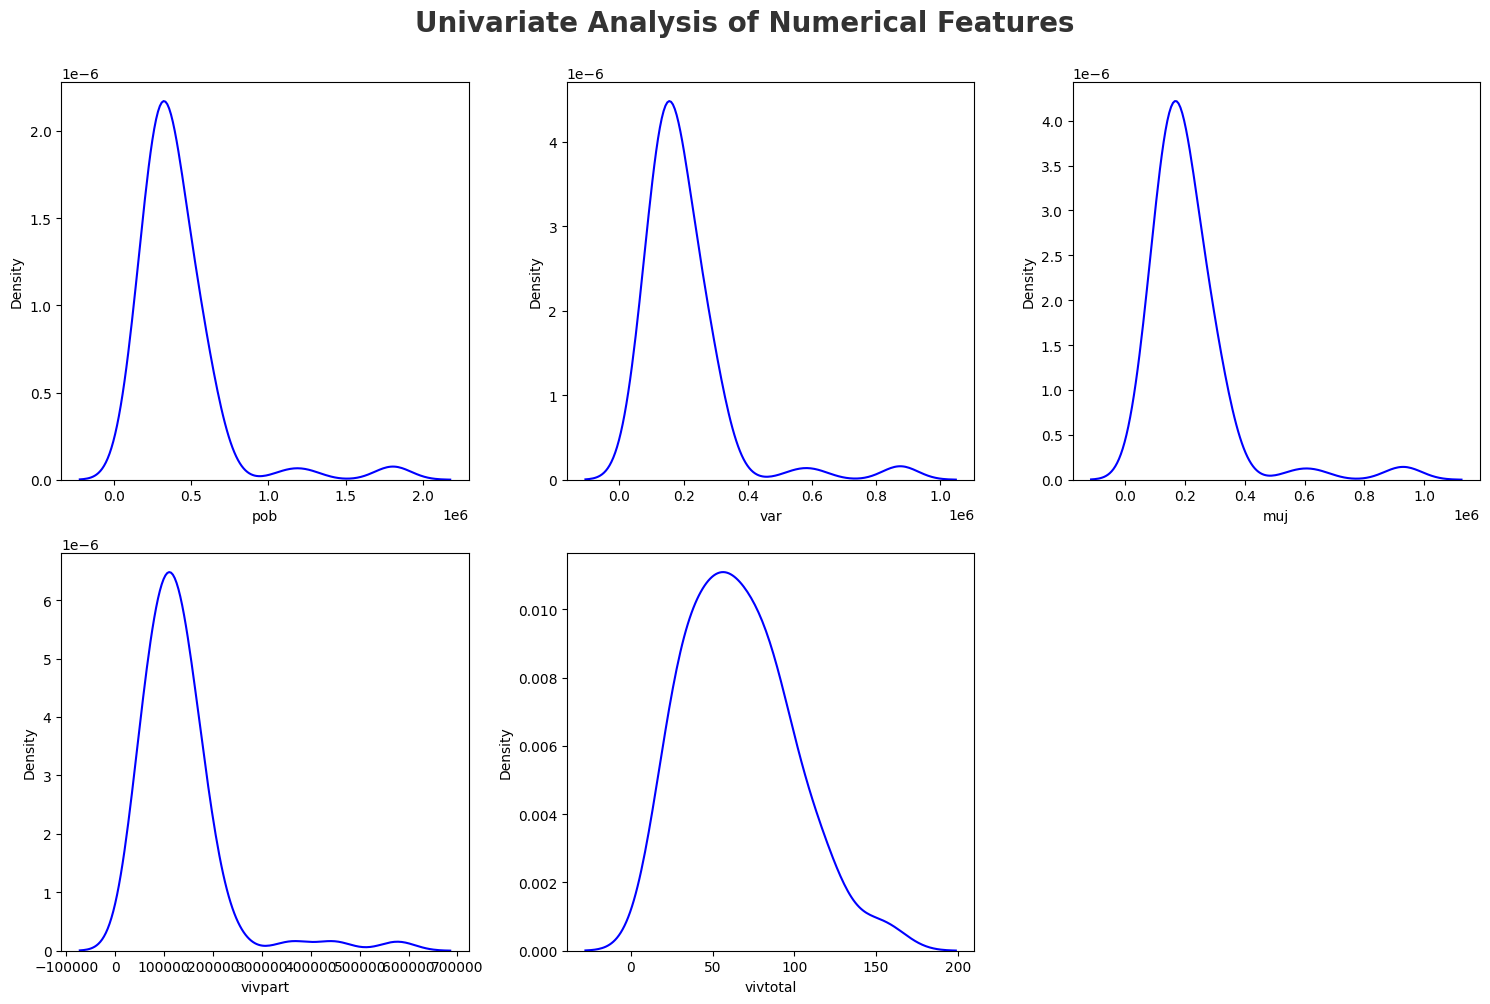

In [7]:
plt.figure(figsize=(15,10))
plt.suptitle('Univariate Analysis of Numerical Features', fontsize=20, fontweight='bold',alpha=0.8, y=1.) 

for i in range(0, len(numeric_features)):
    plt.subplot(2,3, i+1)
    sns.kdeplot(x=df[numeric_features[i]], color='blue')
    plt.xlabel(numeric_features[i])
    plt.tight_layout()

In [8]:
## NAN VALUES
nan_values = df.isna().sum()
print(nan_values)

## Fill NAN values with none
df_filled = df.fillna(0)     ## Specific columm -->##{'pob': 0}
nan_values = df_filled.isna().sum()
print(nan_values)
df=df_filled



# df_filled = df.fillna({'pob': 0})
# nan_values = df_filled.isna().sum()
# print(nan_values)
# df=df_filled

nam           0
cod_depto     0
anio          0
pob           6
var           6
muj           6
vivpart      24
vivtotal     24
sup           0
ind_masc      6
dens_pob      6
dtype: int64
nam          0
cod_depto    0
anio         0
pob          0
var          0
muj          0
vivpart      0
vivtotal     0
sup          0
ind_masc     0
dens_pob     0
dtype: int64


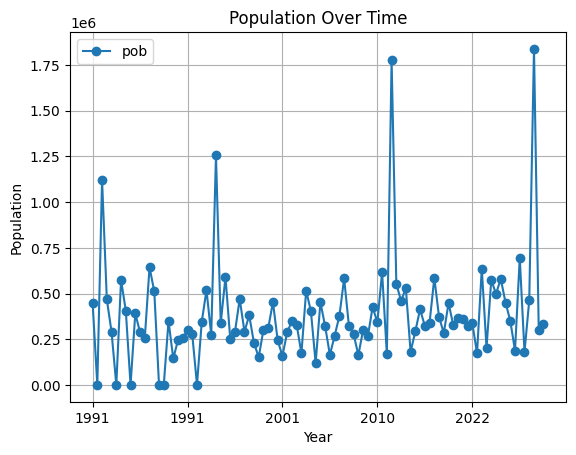

In [9]:
df = df.sort_values(by='anio')
df.plot(x='anio', y='pob', kind='line', marker='o')  # 'line' plot with markers
plt.title('Population Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()


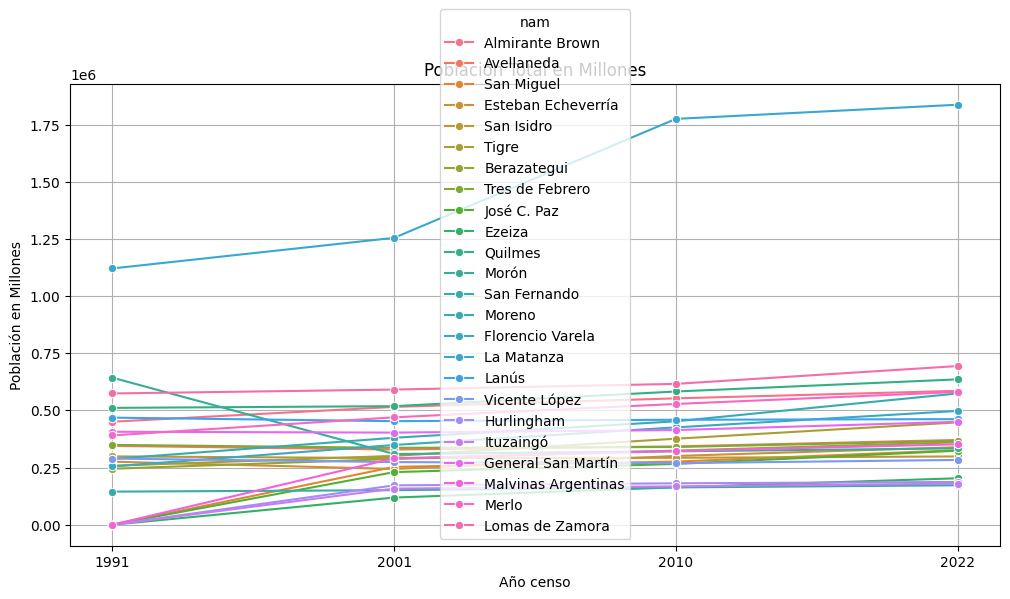

In [10]:
df = df.sort_values(by='anio')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='anio', y='pob',hue='nam', marker='o')
plt.title('Población Total en Millones')
plt.xlabel('Año censo')
plt.ylabel('Población en Millones')
plt.grid(True)
plt.show()

In [11]:
# import custom fucntions
from utils import categorize_dens_pob
from utils import categorize_sup

# Apply the function to create a new column
df['sup_category'] = df['sup'].apply(categorize_sup)
df_cleaned = df.dropna(subset=['dens_pob'])
df=df_cleaned
df['dens_category'] = df['dens_pob'].apply(categorize_dens_pob)
df = df.sort_values(by='anio')
# Check the DataFrame after categorizing
print(df)


                    nam cod_depto  anio       pob       var       muj  \
35      Almirante Brown     06028  1991  450698.0  222042.0  228656.0   
91      Lomas de Zamora     06490  1991  574330.0  278877.0  295453.0   
39                Merlo     06539  1991  390858.0  193521.0  197337.0   
59  Malvinas Argentinas     06515  1991       0.0       0.0       0.0   
63   General San Martín     06371  1991  406809.0  196417.0  210392.0   
..                  ...       ...   ...       ...       ...       ...   
36                Merlo     06539  2022  580806.0  281098.0  298729.0   
76     Florencio Varela     06274  2022  497818.0  239305.0  250192.0   
80              Quilmes     06658  2022  636026.0  304299.0  329672.0   
28               Ezeiza     06270  2022  203283.0   97766.0  102703.0   
52                Morón     06568  2022  334178.0  156891.0  175565.0   

     vivpart  vivtotal     sup ind_masc dens_pob sup_category dens_category  
35       0.0       0.0  157.87     97.1  2854

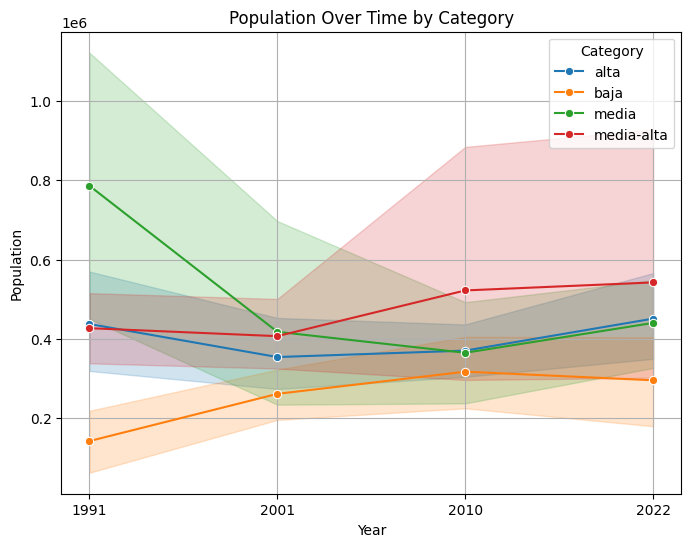

In [12]:
# Grouping the data by the specified column (replace 'column_name' with the actual column name)
grouped_df = df.groupby('dens_category')

# Plotting each group separately
plt.figure(figsize=(8, 6))
for name, group in grouped_df:
    sns.lineplot(data=group, x='anio', y='pob', marker='o' ,label=name)

plt.title('Population Over Time by Category')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(title='Category')
plt.grid(True)
plt.show()




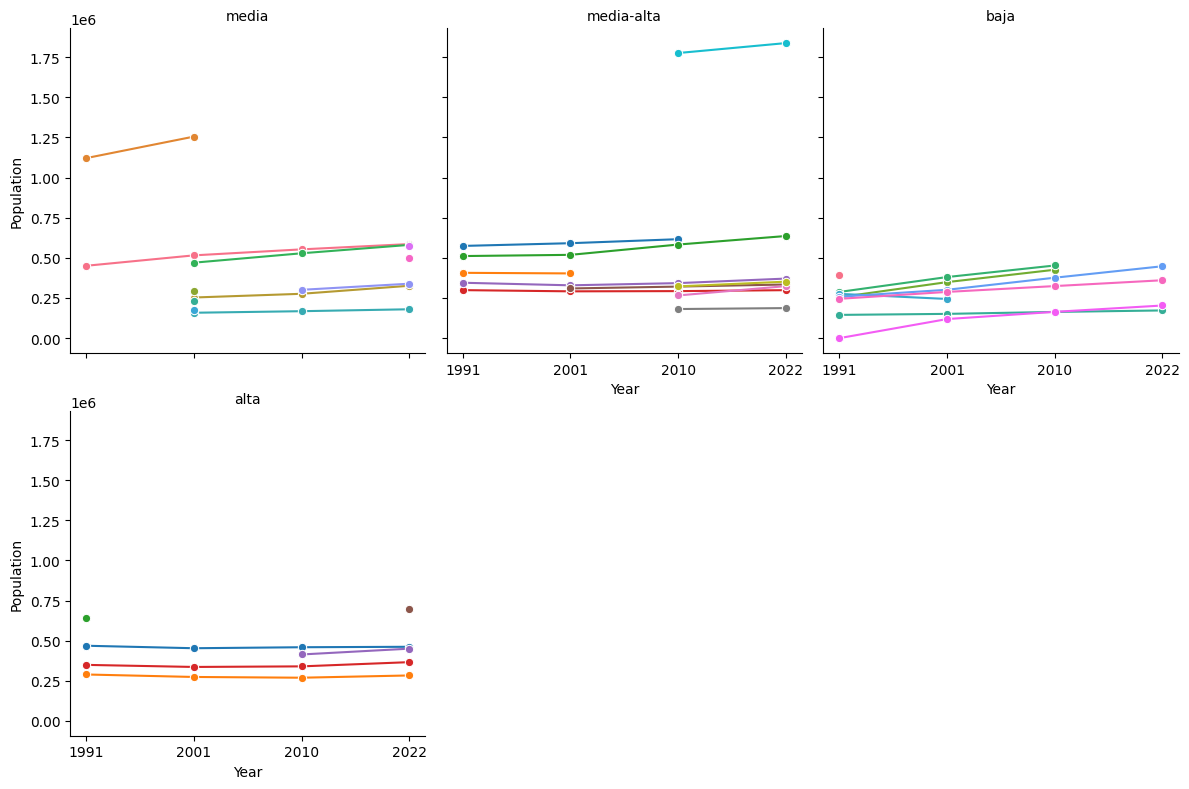

In [13]:

# Create a FacetGrid with a plot for each distinct value in 'dens_category'
g = sns.FacetGrid(df, col='dens_category', col_wrap=3, height=4)
g.map(sns.lineplot, 'anio', 'pob', 'nam', marker='o')
g.set_titles('{col_name}')
g.set_axis_labels('Year', 'Population')
g.tight_layout()
plt.show()


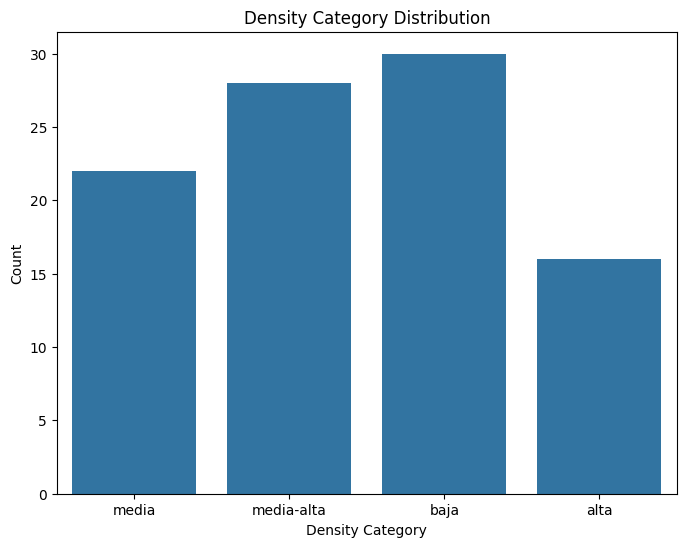

In [14]:
# Create a count plot for the 'dens_category' column
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='dens_category')
plt.title('Density Category Distribution')
plt.xlabel('Density Category')
plt.ylabel('Count')
plt.show()

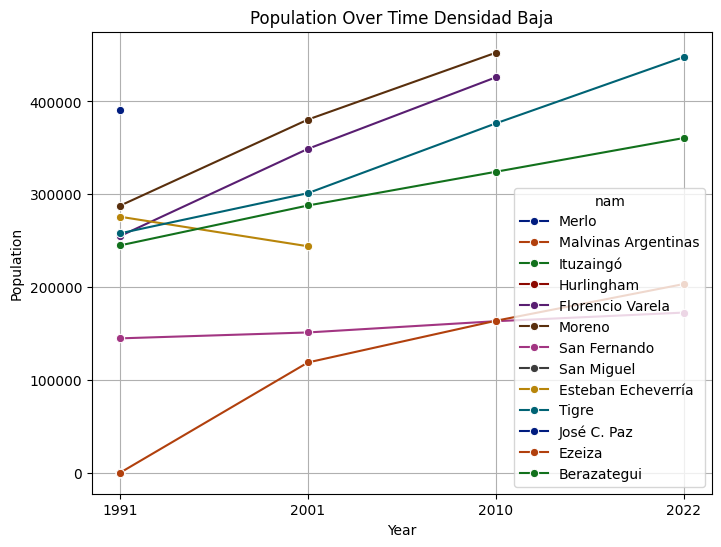

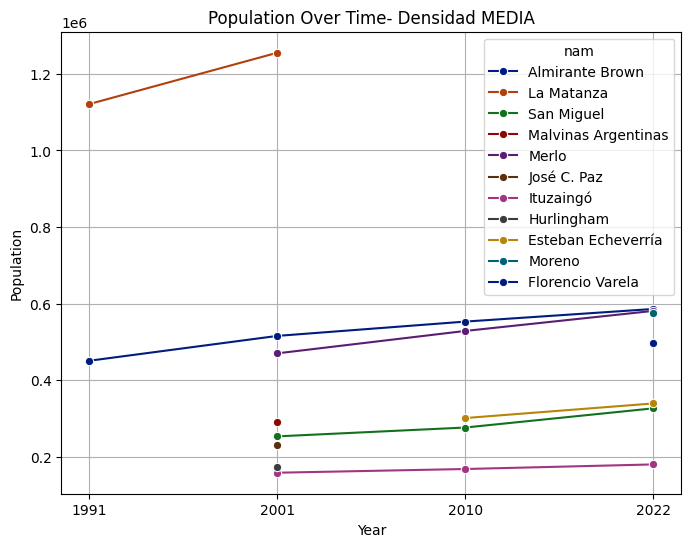

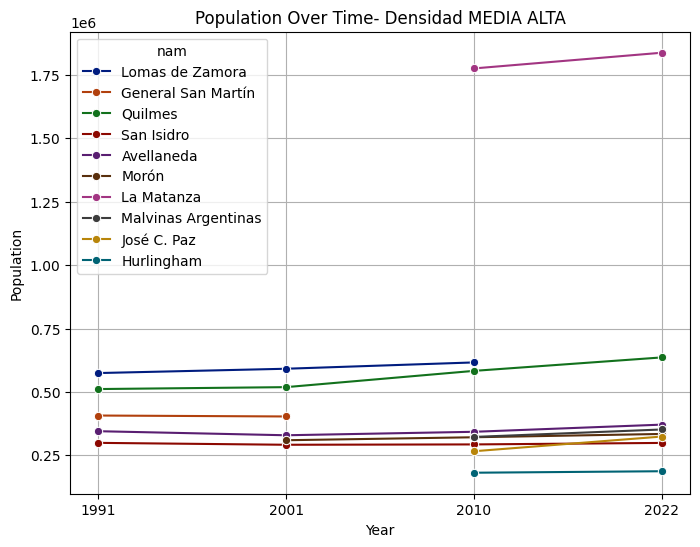

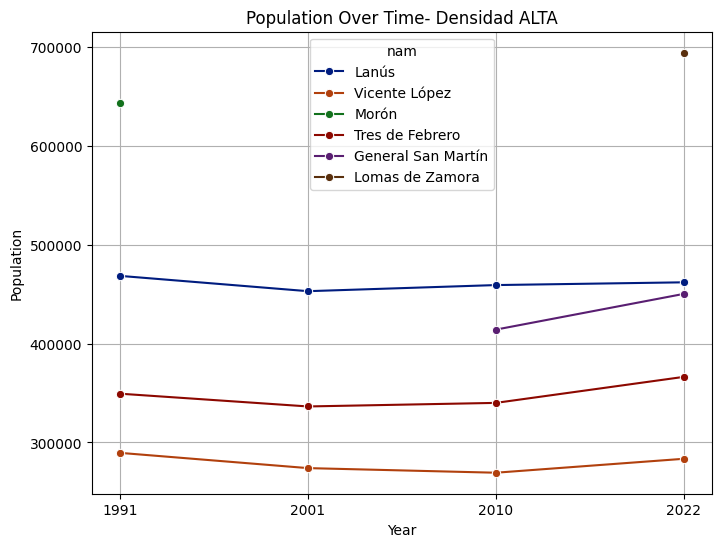

In [15]:
# Filter the DataFrame for rows where dens_category is 'baja'
df_baja = df[df['dens_category'] == 'baja']
# Sort the DataFrame by the 'anio' column
df_baja_sorted = df_baja.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_baja_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time Densidad Baja')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()

# Filter the DataFrame for rows where dens_category is 'baja'
df_media = df[df['dens_category'] == 'media']
# Sort the DataFrame by the 'anio' column
df_media_sorted = df_media.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_media_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time- Densidad MEDIA')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()
# Filter the DataFrame for rows where dens_category is 'media-alta'
df_media_alta = df[df['dens_category'] == 'media-alta']
# Sort the DataFrame by the 'anio' column
df_media_alta_sorted = df_media_alta.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_media_alta_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time- Densidad MEDIA ALTA')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()
 #Filter the DataFrame for rows where dens_category is 'media-alta'
df_alta = df[df['dens_category'] == 'alta']
# Sort the DataFrame by the 'anio' column
# Sort the DataFrame by the 'anio' column
df_alta_sorted = df_alta.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_alta_sorted, x='anio', y='pob',hue='nam',palette='dark', marker='o')
plt.title('Population Over Time- Densidad ALTA')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)
plt.show()

           nam cod_depto  anio        pob       var       muj   vivpart  \
15  La Matanza     06427  1991  1121298.0  551408.0  569890.0       0.0   
14  La Matanza     06427  2001  1255288.0  612967.0  642321.0  361099.0   
13  La Matanza     06427  2010  1775816.0  866690.0  909126.0  447371.0   
12  La Matanza     06427  2022  1837774.0  883023.0  950847.0  577276.0   

    vivtotal     sup ind_masc dens_pob sup_category dens_category  
15       0.0  399.51     96.8  2806.68   muy grande         media  
14     158.0  399.51     95.4  3142.07   muy grande         media  
13     149.0  399.51     95.3  4444.99   muy grande    media-alta  
12     126.0  399.51     92.9  4600.07   muy grande    media-alta  


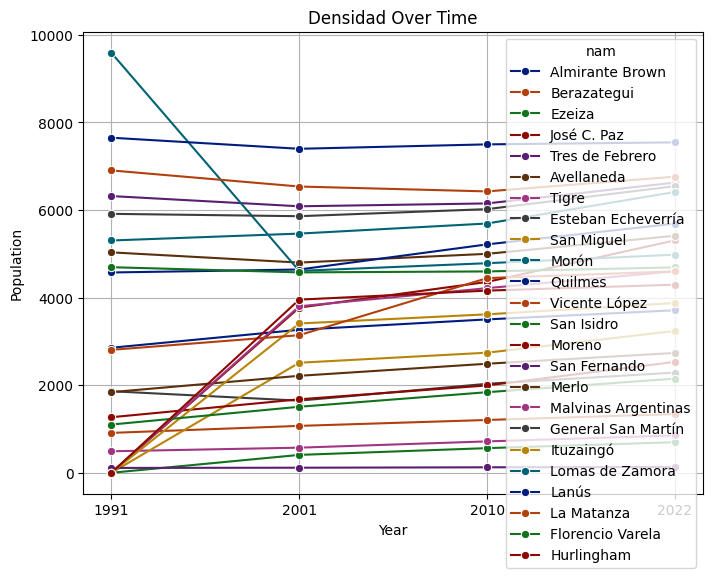

In [16]:
print( df[df['nam'] == 'La Matanza'])
### DENSIDAD
df = df.sort_values(by='anio')
plt.figure(figsize=(8, 6))
sns.lineplot(data=df, x='anio', y='dens_pob',hue='nam',palette='dark', marker='o')
plt.title('Densidad Over Time')
plt.xlabel('Year')
plt.ylabel('Population')
plt.grid(True)

                 nam  anio        pob  growth_ratio
35   Almirante Brown  1991   450698.0           NaN
51        Hurlingham  1991        0.0           NaN
79  Florencio Varela  1991   254997.0           NaN
15        La Matanza  1991  1121298.0           NaN
87             Lanús  1991   468561.0           NaN
..               ...   ...        ...           ...
84             Lanús  2022   462051.0      0.607060
8             Moreno  2022   574374.0     26.932078
72   Tres de Febrero  2022   366377.0      7.735443
88   Lomas de Zamora  2022   694330.0     12.664881
52             Morón  2022   334178.0      4.069958

[96 rows x 4 columns]


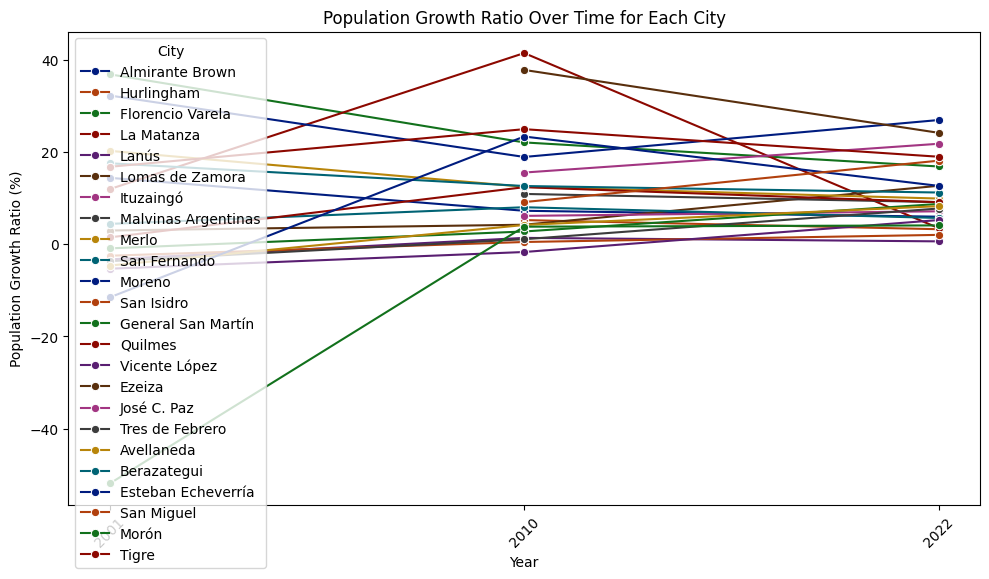

In [17]:
# Sort the DataFrame by 'anio'
df_sorted = df.sort_values(by='anio')

# Calculate the growth ratio (percentage change) for 'pob' for each city ('nam') and each year ('anio')
df_sorted['growth_ratio'] = df_sorted.groupby('nam')['pob'].pct_change() * 100

# Display the DataFrame with the growth ratio
print(df_sorted[['nam', 'anio', 'pob', 'growth_ratio']])


plt.figure(figsize=(10, 6))
sns.lineplot(data=df_sorted, x='anio', y='growth_ratio', hue='nam',palette='dark', marker='o')

# Set plot title and labels
plt.title('Population Growth Ratio Over Time for Each City')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='City', loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


In [18]:

# Drop rows with NaN growth ratios
df_cleaned = df_sorted.dropna(subset=['growth_ratio'])

# Select the growth ratio column for clustering
X = df_cleaned[['growth_ratio']]

# Define the number of clusters (you can adjust this based on your preference)
num_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X)

# Display the DataFrame with cluster assignments
print(df_cleaned[['nam', 'growth_ratio', 'cluster']])

# Calculate cluster centers (mean growth ratio) for each cluster
cluster_centers = df_cleaned.groupby('cluster')['growth_ratio'].mean()
print("Cluster Centers (Mean Growth Ratio):")
print(cluster_centers)


# Create a scatter plot to visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='anio', y='growth_ratio', hue='cluster', palette='Set1', marker='o')

# Set plot title and labels
plt.title('Cities Grouped by Growth Ratio Clusters')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Show legend
plt.legend(title='Cluster')

# Show plot
plt.tight_layout()
plt.show()


ValueError: Input X contains infinity or a value too large for dtype('float64').

In [ ]:
# Create a line plot for growth ratio by year for each cluster
plt.figure(figsize=(10, 6))
for cluster_id in df_cleaned['cluster'].unique():
    cluster_data = df_cleaned[df_cleaned['cluster'] == cluster_id]
    sns.lineplot(data=cluster_data, x='anio', y='growth_ratio', label=f'Cluster {cluster_id}')

# Set plot title and labels
plt.title('Population Growth Ratio Over Time for Each Cluster')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Show legend
plt.legend(title='Cluster')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
# Assuming df_cleaned contains the DataFrame with growth ratios and cluster assignments

# Iterate over unique cluster IDs and print rows for each cluster
for cluster_id in df_cleaned['cluster'].unique():
    cluster_data = df_cleaned[df_cleaned['cluster'] == cluster_id]
    print(f"Cluster {cluster_id}:\n{cluster_data}\n")


In [ ]:

cluster_2_data = df_cleaned[df_cleaned['cluster'] == 2]
print(cluster_2_data)
plt.figure(figsize=(10, 6))
sns.lineplot(data=cluster_2_data, x='anio', y='growth_ratio', hue='nam',palette='dark', marker='o')

# Set plot title and labels
plt.title('Population Growth Ratio Over Time for Each City')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='City', loc='upper left')

# Show plot
plt.tight_layout()
plt.show()
print()


In [ ]:
# Assuming df_cleaned contains the DataFrame with growth rates and cluster assignments


# Sort the DataFrame by the 'nam' column
df_cleaned_sorted = df_cleaned.sort_values(by='nam')
distinct_nam_values = cluster_2_data['nam'].unique()

# Select rows from df_another where the 'nam' column is in the distinct values obtained
cluster2cities = df_cleaned_sorted[df_cleaned_sorted['nam'].isin(distinct_nam_values)]

# Display selected rows
print(cluster2cities)



plt.figure(figsize=(10, 6))
sns.lineplot(data=cluster2cities, x='anio', y='growth_ratio', hue='nam',palette='dark', marker='o')

# Set plot title and labels
plt.title('Population Growth Ratio Over Time for Each City')
plt.xlabel('Year')
plt.ylabel('Population Growth Ratio (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='City', loc='upper left')

# Show plot
plt.tight_layout()
plt.show()
print()

#######################_____________VER EN ESTE GRAFICO LA MATANZA_______________________###########

In [ ]:
# Assuming df_cleaned contains the DataFrame with growth rates and cluster assignments

# Calculate the standard deviation of growth rates for each city
std_deviation_per_city = cluster2cities.groupby('nam')['growth_ratio'].std()

# Calculate the coefficient of variation (CV) of growth rates for each city
mean_growth_rate_per_city = cluster2cities.groupby('nam')['growth_ratio'].mean()
cv_per_city = (std_deviation_per_city / mean_growth_rate_per_city) * 100

# Display the standard deviation and coefficient of variation per city
print("Standard Deviation of Growth Rates per City:")
print(std_deviation_per_city)
print("\nCoefficient of Variation (CV) of Growth Rates per City:")
print(cv_per_city)


In [ ]:
# Plot the standard deviation of growth rates per city
plt.figure(figsize=(10, 6))
std_deviation_per_city.plot(kind='bar', color='skyblue')
plt.title('Standard Deviation of Growth Rates per City')
plt.xlabel('City')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the coefficient of variation (CV) of growth rates per city
plt.figure(figsize=(10, 6))
cv_per_city.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Se ve la matanza y E etcheverria.... pero E Etch ha sufrido modificaciones.

In [ ]:
# Read poblacion
df_dimdepto = read_table_into_dataframe('public.dimdepto')
if df_dimdepto is not None:
    print(df_dimdepto)

In [ ]:
# Select rows where 'comments' column is not equal to 'none'
df_depto_changed = df_dimdepto[df_dimdepto['Comentarios'].notna()]
deptos_changed= df_depto_changed[['Departamento', 'Comentarios']]
# Display the filtered DataFrame0

unique_department_names = deptos_changed['Departamento'].unique()

departments_exist = cluster2cities['nam'].isin(unique_department_names)

# Filter df_cluster2cities to get the rows where department names exist
df_cluster2cities_filtered = cluster2cities[departments_exist]

# Display the filtered DataFrame
print(df_cluster2cities_filtered)
cluster2citiesDeptoschanged = df_cluster2cities_filtered['nam'].unique()
print(cluster2citiesDeptoschanged)

In [ ]:
### NOW FOR ALL dpetos not only cluster 2

# Drop rows with NaN growth ratios
df_cleaned = df_sorted.dropna(subset=['growth_ratio'])

# Select the growth ratio column for clustering
X = df_cleaned[['growth_ratio']]

# Define the number of clusters (you can adjust this based on your preference)
num_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X)

# Display the DataFrame with cluster assignments
print(df_cleaned[['nam', 'growth_ratio', 'cluster']])

# Calculate cluster centers (mean growth ratio) for each cluster
cluster_centers = df_cleaned.groupby('cluster')['growth_ratio'].mean()

## sort
df_allcities = df_cleaned.sort_values(by='nam')


## DEVIATION
std_deviation_per_city = df_allcities.groupby('nam')['growth_ratio'].std()

# Calculate the coefficient of variation (CV) of growth rates for each city
mean_growth_rate_per_city = df_allcities.groupby('nam')['growth_ratio'].mean()
cv_per_city = (std_deviation_per_city / mean_growth_rate_per_city) * 100

# Display the standard deviation and coefficient of variation per city
print("Standard Deviation of Growth Rates per City:")
print(std_deviation_per_city)
print("\nCoefficient of Variation (CV) of Growth Rates per City:")
print(cv_per_city)
# Plot the standard deviation of growth rates per city
plt.figure(figsize=(10, 6))
std_deviation_per_city.plot(kind='bar', color='skyblue')
plt.title('Standard Deviation of Growth Rates per City')
plt.xlabel('City')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the coefficient of variation (CV) of growth rates per city
plt.figure(figsize=(10, 6))
cv_per_city.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Sort the DataFrame by the coefficient of variation (CV) values in ascending order
sorted_cv = cv_per_city.sort_values()

# Plot the sorted coefficient of variation (CV) values per city
plt.figure(figsize=(10, 6))
sorted_cv.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City (Sorted)')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





df_depto_changed = df_dimdepto[df_dimdepto['Comentarios'].notna()]
deptos_changed= df_depto_changed[['Departamento', 'Comentarios']]
# Display the filtered DataFrame0

unique_department_names = deptos_changed['Departamento'].unique()

departments_exist = df_allcities['nam'].isin(unique_department_names)

# Filter df_cluster2cities to get the rows where department names exist
changedDeptos = df_allcities[departments_exist]

# Display the filtered DataFrame
print(changedDeptos)




In [ ]:
print("Unique values of 'nam' in cv_per_city:")
print(cv_per_city.index.unique())

print("\nUnique values of 'Departamento' in deptos_changed:")
print(deptos_changed['Departamento'].unique())
# Assuming cv_per_city is the Series with coefficient of variation per city
# and deptos_changed is the DataFrame with department names

# Get unique department names from deptos_changed
unique_department_names = deptos_changed['Departamento'].unique()

# Exclude department names from cv_per_city
cv_per_city_excluded = cv_per_city.drop(index=unique_department_names, errors='ignore')

# Sort the excluded Series
sorted_cv_excluded = cv_per_city_excluded.sort_values()

# Plot the sorted coefficient of variation (CV) values per city EXCLUDING DEPTOS CHANGED
plt.figure(figsize=(10, 6))
sorted_cv_excluded.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City (Excluding deptos_changed)')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Drop rows where the index (city name) is equal to 'San Isidro'
cv_per_city_filtered = cv_per_city.drop(index='San Isidro', errors='ignore')

# Sort the filtered Series
sorted_cv_filtered = cv_per_city_filtered.sort_values()

# Plot the sorted coefficient of variation (CV) values per city
plt.figure(figsize=(10, 6))
sorted_cv_filtered.plot(kind='bar', color='lightgreen')
plt.title('Coefficient of Variation (CV) of Growth Rates per City (Excluding San Isidro)')
plt.xlabel('City')
plt.ylabel('Coefficient of Variation (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()